In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import cross_val_predict,cross_val_score,train_test_split,GridSearchCV

In [3]:
from sklearn.neighbors import KNeighborsRegressor,KNeighborsClassifier

In [4]:
from sklearn.metrics import confusion_matrix,precision_score, recall_score,f1_score

In [5]:
from sklearn.svm import SVC

In [6]:
from sklearn.compose import make_column_selector, make_column_transformer, ColumnTransformer

In [7]:
from sklearn.multioutput import ClassifierChain

In [8]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784',as_frame=False,parser='liac-arff')

In [9]:
X,y = mnist.data,mnist.target

In [10]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [11]:
X_train.shape,y_train.shape

((56000, 784), (56000,))

In [12]:
kn_clf = KNeighborsClassifier()


In [13]:
y_train_large = (y_train >='7')
y_train_odd = (y_train.astype('int8')%2==1)
y_multilabel = np.c_[y_train_large,y_train_odd]

In [14]:
kn_clf.fit(X_train,y_multilabel)

KNeighborsClassifier()

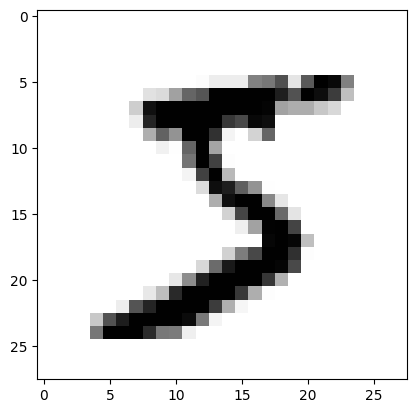

In [15]:
plt.imshow(X[0].reshape(28,28),cmap='binary')
plt.show()

In [16]:
y_train_pred = cross_val_predict(kn_clf,X_train,y_multilabel,cv=3)

In [17]:
import sklearn
print("scikit-learn version:", sklearn.__version__)

scikit-learn version: 1.6.1


In [18]:
f1_score(y_train_pred,y_multilabel,average='macro')

0.9759770524441204

In [19]:
chain_clf = ClassifierChain(SVC(),cv=3,random_state=42)

In [20]:
chain_clf.fit(X_train[:2000],y_multilabel[:2000])

ClassifierChain(base_estimator=SVC(), cv=3, random_state=42)

In [22]:
chain_clf.predict(X_test)

array([[1., 0.],
       [0., 0.],
       [0., 1.],
       ...,
       [0., 0.],
       [1., 1.],
       [0., 1.]])

### **(A)**  `f1_score()` 

in scikit-learn to evaluate a classification model, the `average` parameter determines how the F1 score is calculated, especially in **multi-class or multi-label** settings. Choosing the right averaging method is crucial for correct interpretation. Here’s a breakdown of the options and when to use each:

---

### **Options for `average=` in `f1_score()`**
| Parameter      | Description                                                                 | Use Case                                                                 |
|---------------|-----------------------------------------------------------------------------|--------------------------------------------------------------------------|
| **`'binary'`** | Default. Computes F1 for the **positive class only** (assumes binary classification). | Binary classification (only 2 classes).                                 |
| **`'micro'`**  | Global F1 by **counting total TP, FP, FN** across all classes.              | Class imbalance + you care about overall performance.                   |
| **`'macro'`**  | **Unweighted mean** of F1 across classes (treats all classes equally).      | Multi-class, no class imbalance.                                        |
| **`'weighted'`**| **Weighted mean** of F1 (by class support, i.e., # of samples per class).   | Class imbalance + you want to account for class frequencies.            |
| **`'samples'`** | F1 for **each instance** (multi-label only), then average.                  | Multi-label classification (each sample can have multiple labels).       |

---

### **How to Choose the Right `average`**
#### 1. **Binary Classification**
```python
from sklearn.metrics import f1_score

y_true = [0, 1, 1, 0]
y_pred = [0, 1, 0, 0]

# Default: 'binary' (positive class = 1)
f1 = f1_score(y_true, y_pred, average='binary')  # Equivalent to average=None
```
**Output:**  
F1 for class `1` only (e.g., `0.66`).

---

#### 2. **Multi-Class Classification (Imbalanced Data)**
```python
y_true = [0, 1, 2, 0, 1, 2]
y_pred = [0, 2, 1, 0, 0, 1]

# Macro (equal weight per class)
f1_macro = f1_score(y_true, y_pred, average='macro')  # (F1_class0 + F1_class1 + F1_class2) / 3

# Weighted (adjusts for class imbalance)
f1_weighted = f1_score(y_true, y_pred, average='weighted')  # Weighted by # samples per class
```
**Key Difference:**  
- `macro` treats all classes equally.  
- `weighted` favors larger classes.  

---

#### 3. **Multi-Label Classification**
```python
from sklearn.preprocessing import MultiLabelBinarizer

y_true = [[0, 1], [1], [0, 1, 2], [2]]
y_pred = [[0, 1], [1], [0, 2], [1, 2]]

# Binarize labels
mlb = MultiLabelBinarizer()
y_true_bin = mlb.fit_transform(y_true)
y_pred_bin = mlb.transform(y_pred)

# Samples-wise average
f1_samples = f1_score(y_true_bin, y_pred_bin, average='samples')  # F1 per sample, then averaged
```

---

### **When to Use Which?**
| Scenario                          | Recommended `average` |
|-----------------------------------|-----------------------|
| Binary classification             | `'binary'`            |
| Multi-class, balanced classes     | `'macro'`             |
| Multi-class, imbalanced classes   | `'weighted'`          |
| Multi-label classification        | `'samples'` or `'micro'` |

---

### **Example with `KNeighborsClassifier` (MNIST)**
```python
from sklearn.datasets import load_digits
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

# Load data
X, y = load_digits(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Train model
model = KNeighborsClassifier()
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)

# Macro-F1 (equal weight for all 10 digits)
f1_macro = f1_score(y_test, y_pred, average='macro')

# Weighted-F1 (adjusts for digit frequency)
f1_weighted = f1_score(y_test, y_pred, average='weighted')
```

---

### **Common Pitfalls**
1. **Using `'binary'` for multi-class**: Will raise an error (use `'macro'`, `'micro'`, or `'weighted'`).  
2. **Ignoring class imbalance**: `'macro'` can mislead if classes are imbalanced.  
3. **Misusing `'samples'`**: Only for multi-label, not multi-class.

---

### **Final Tip**
- For **imbalanced datasets**, `average='weighted'` is often safest.  
- For **research papers**, specify which averaging method you used.  


### **(B). Multi-Class vs. Multi-Label Classification**

The main difference lies in **how many labels/classes each sample can have**:

| Feature               | Multi-Class Classification           | Multi-Label Classification           |
|-----------------------|--------------------------------------|--------------------------------------|
| **Definition**        | Each sample belongs to **one** class. | Each sample can have **multiple** labels. |
| **Output**           | Single class prediction (e.g., "Cat"). | Multiple labels (e.g., ["Cat", "Sunny"]). |
| **Use Case**         | MNIST digits, Iris flower species.   | Photo tagging (e.g., "Beach", "Sunset", "Dog"). |
| **Example**          | Predict if an image is a Cat/Dog/Bird. | Tag a photo as ["Cat", "Indoor", "Cute"]. |
| **Mathematical Form** | Mutually exclusive classes (softmax). | Independent binary classifications (sigmoid). |
| **Scikit-Learn Metrics** | Use `average='macro'` or `'weighted'`. | Use `average='samples'` or `'micro'`. |

---

### **1. Multi-Class Classification**
- **Each sample belongs to exactly one class** (mutually exclusive).  
- **Example**:  
  - **Task**: Predict animal type (Cat, Dog, Bird).  
  - **Truth**: `["Dog"]` → Model must pick **one** class.  
- **Model Output**: Probability distribution over classes (softmax).  
- **Metrics**:  
  ```python
  from sklearn.metrics import f1_score
  f1_score(y_true, y_pred, average='macro')  # Treats all classes equally.
  ```

---

### **2. Multi-Label Classification**
- **Each sample can have multiple labels simultaneously** (non-exclusive).  
- **Example**:  
  - **Task**: Tag a photo (e.g., "Sunny", "Beach", "Dog").  
  - **Truth**: `["Sunny", "Beach"]` → Model predicts **a subset of labels**.  
- **Model Output**: Binary predictions per label (sigmoid).  
- **Metrics**:  
  ```python
  f1_score(y_true, y_pred, average='samples')  # F1 per sample, then averaged.
  ```

---

### **Visual Comparison**
#### **Multi-Class (One Label per Sample)**
```
Sample 1: "Cat"  
Sample 2: "Dog"  
Sample 3: "Bird"  
```

#### **Multi-Label (Multiple Labels per Sample)**
```
Sample 1: ["Cat", "Indoor"]  
Sample 2: ["Dog", "Outdoor", "Sunny"]  
Sample 3: []  # No labels.
```

---

### **Key Technical Differences**
| Aspect                | Multi-Class                          | Multi-Label                          |
|-----------------------|--------------------------------------|--------------------------------------|
| **Output Layer**      | Softmax (sums to 1)                  | Sigmoid (independent probabilities)  |
| **Loss Function**     | Cross-Entropy                        | Binary Cross-Entropy                 |
| **Evaluation**        | Accuracy, F1 (macro/weighted)        | F1 (samples/micro), Precision@K      |
| **Algorithms**        | `LogisticRegression`, `RandomForest` | `BinaryRelevance`, `ClassifierChain` |

---

### **When to Use Which?**
- **Multi-Class**:  
  - Problems with **mutually exclusive** classes (e.g., digit recognition).  
- **Multi-Label**:  
  - Problems where **labels can co-occur** (e.g., text tagging, medical diagnoses).  

---

### **Example in Scikit-Learn**
#### **Multi-Class (Digits Dataset)**
```python
from sklearn.datasets import load_digits
from sklearn.svm import SVC

X, y = load_digits(return_X_y=True)  # y = [0, 1, 2, ..., 9]
model = SVC().fit(X, y)
pred = model.predict(X)  # Output: [0, 3, 9, ...]
```

#### **Multi-Label (Fake Tags Dataset)**
```python
from sklearn.preprocessing import MultiLabelBinarizer

y_true = [["Cat", "Indoor"], ["Dog", "Outdoor"], ["Cat"]]  # Multi-label
mlb = MultiLabelBinarizer()
y_bin = mlb.fit_transform(y_true)  # Convert to binary matrix

# Train a classifier (e.g., OneVsRest)
from sklearn.multiclass import OneVsRestClassifier
model = OneVsRestClassifier(SVC()).fit(X, y_bin)
pred = model.predict(X)  # Output: [[1, 1, 0], [0, 1, 1], ...]
```

---

### **Summary**
- **Multi-Class**: "What is this?" (Single answer).  
- **Multi-Label**: "What is in this?" (Multiple tags).  

For imbalanced multi-label data, prefer `average='micro'` or `'samples'` in `f1_score()`.  🚀

### **(C). Classifier Chains**

Multi-Label Classification with Dependencies

**Classifier Chains** is a sophisticated method for **multi-label classification** that leverages label dependencies (i.e., correlations between labels) to improve prediction accuracy. Unlike simpler approaches like **Binary Relevance** (which treats each label independently), it models label relationships by chaining classifiers sequentially.

---

## **Key Concepts**
### 1. **How It Works**
- **Step 1:** Train a binary classifier for each label (like Binary Relevance).  
- **Step 2:** **Chain the classifiers**: Each classifier in the chain uses the predictions of previous classifiers as additional features.  
- **Step 3:** Predict labels in the order of the chain.  

### 2. **Example**
Suppose we have 3 labels: `[A, B, C]` and a predefined chain order `A → B → C`.  
- **Classifier for A:** Uses only input features `X`.  
- **Classifier for B:** Uses `X + prediction of A`.  
- **Classifier for C:** Uses `X + predictions of A and B`.  

This way, label correlations are captured.

---

## **Why Use Classifier Chains?**
| Approach | Handles Label Dependencies? | Scalability | Performance |
|----------|----------------------------|-------------|-------------|
| **Binary Relevance** | ❌ No (independent labels) | ✅ High | ⚠️ Suboptimal if labels are correlated |
| **Classifier Chains** | ✅ Yes (models dependencies) | ⚠️ Moderate | ✅ Better if labels are correlated |
| **Label Powerset** | ✅ Yes (treats combinations as classes) | ❌ Low (for many labels) | ✅ Best but computationally expensive |

**Classifier Chains strike a balance** between performance and scalability.

---

## **Implementation in Scikit-Learn**
### **1. Basic Usage**
```python
from sklearn.multioutput import ClassifierChain
from sklearn.linear_model import LogisticRegression

# Example: Multi-label dataset (X_train, Y_train)
model = ClassifierChain(
    LogisticRegression(),  # Base binary classifier
    order='random',        # Chain order: 'random', 'default', or custom list
    random_state=42
)
model.fit(X_train, Y_train)
predictions = model.predict(X_test)
```

### **2. Custom Chain Order**
```python
# Force order: Label2 → Label1 → Label3
chain_order = [1, 0, 2]  # Column indices of Y_train
model = ClassifierChain(LogisticRegression(), order=chain_order)
```

### **3. Ensemble of Chains (ECC)**
Since the chain order affects results, **Ensemble Classifier Chains (ECC)** trains multiple chains with random orders and averages predictions:
```python
from sklearn.multioutput import ClassifierChain
from sklearn.ensemble import RandomForestClassifier

# Train 5 chains with random orders
chains = [ClassifierChain(RandomForestClassifier(), order='random') 
          for _ in range(5)]
for chain in chains:
    chain.fit(X_train, Y_train)

# Average predictions
predictions = np.mean([chain.predict(X_test) for chain in chains], axis=0)
predictions = (predictions > 0.5).astype(int)  # Threshold
```

---

## **When to Use Classifier Chains?**
✅ **Label dependencies exist** (e.g., in text tagging, `"beach"` often co-occurs with `"sunny"`).  
✅ **Moderate-sized datasets** (faster than Label Powerset).  
❌ **Avoid if** labels are completely independent (use Binary Relevance instead).  

---

## **Pros & Cons**
| Pros | Cons |
|------|------|
| Captures label dependencies | Sensitive to chain order |
| Better accuracy than Binary Relevance | Slower than Binary Relevance |
| Scalable compared to Label Powerset | May propagate errors down the chain |

---

## **Comparison with Other Methods**
| Method | Handles Dependencies? | Prediction Complexity |
|--------|----------------------|----------------------|
| **Binary Relevance** | ❌ No | O(k) – Fast |
| **Classifier Chains** | ✅ Yes | O(k) – Moderate |
| **Label Powerset** | ✅ Yes | O(2^k) – Slow |

---

## **Final Advice**
- Use **Classifier Chains** when labels are correlated.  
- For robustness, try **Ensemble Classifier Chains (ECC)**.  
- If speed is critical, use **Binary Relevance**.  



### **When and How to Use Classifier Chains (For Non-Native Multi-Label Models)**

 **Classifier Chains** are specifically designed to **enable multi-label classification for models that don’t natively support it** (e.g., Logistic Regression, SVM, Random Forest). Here’s a clear breakdown of how and when to apply it:

---

## **1. Why Use Classifier Chains?**
### **Problem:**
Many traditional classifiers (e.g., `LogisticRegression`, `SVC`, `RandomForest`) are designed for:
- Binary classification (`y ∈ {0, 1}`),  
- Multi-class classification (`y ∈ {0, 1, 2, ...}`).  

They **cannot directly predict multiple labels per sample** (e.g., `y = [1, 0, 1]` for labels `["Action", "Comedy", "Sci-Fi"]`).

### **Solution: Classifier Chains**
- **Wraps a binary classifier** (e.g., Logistic Regression) to predict each label **sequentially**, using prior predictions as features.  
- **Example**:  
  - To predict `[A, B, C]`, it trains:  
    - `Classifier A`: Predicts `A` from features `X`.  
    - `Classifier B`: Predicts `B` from `X + A's prediction`.  
    - `Classifier C`: Predicts `C` from `X + A + B`.  

---

## **2. When to Use Classifier Chains?**
✅ **Use When:**  
- Your **base model (e.g., SVM, RandomForest) doesn’t support multi-label** out of the box.  
- Labels are **correlated** (e.g., `"Beach" → "Sunny"`).  
- You need **better accuracy than Binary Relevance** (which ignores label dependencies).  

❌ **Avoid When:**  
- Your model **already supports multi-label** (e.g., `RandomForest` with `MultiOutputClassifier`).  
- Labels are **independent** (use Binary Relevance instead).  
- You need **low latency** (chains are slower than Binary Relevance).  

---

## **3. How to Implement It**
### **Step 1: Prepare Multi-Label Data**
```python
from sklearn.datasets import make_multilabel_classification

# Synthetic multi-label data (100 samples, 5 features, 3 labels)
X, y = make_multilabel_classification(n_samples=100, n_features=5, n_labels=3, random_state=42)
```

### **Step 2: Train a Classifier Chain**
```python
from sklearn.multioutput import ClassifierChain
from sklearn.linear_model import LogisticRegression

# Wrap LogisticRegression (binary classifier) in a chain
chain = ClassifierChain(
    LogisticRegression(),  # Base model (must support binary classification)
    order='random',        # Order: 'random', 'default', or custom list [0, 1, 2]
    random_state=42
)
chain.fit(X, y)
```

### **Step 3: Predict**
```python
y_pred = chain.predict(X)  # Returns binary multi-label predictions (e.g., [1, 0, 1])
```

---

## **4. Key Parameters**
| Parameter | Description |
|-----------|-------------|
| `base_estimator` | Binary classifier (e.g., `LogisticRegression()`, `SVC()`). |
| `order` | Label prediction order (`'random'`, `'default'`, or custom like `[2, 0, 1]`). |
| `cv` | Cross-validation for chain order selection (optional). |

---

## **5. Pros & Cons**
| **Pros** | **Cons** |
|----------|----------|
| ✅ Enables multi-label for binary models. | ❌ Slower than Binary Relevance. |  
| ✅ Captures label dependencies. | ❌ Sensitive to chain order. |  
| ✅ Works with 10s-100s of labels. | ❌ Errors propagate down the chain. |  

---

## **6. Comparison to Other Methods**
| Method | Handles Dependencies? | Works with Non-Native Models? | Speed |
|--------|----------------------|-----------------------------|-------|
| **Binary Relevance** | ❌ No | ✅ Yes | ⚡ Fastest |
| **Classifier Chains** | ✅ Yes | ✅ Yes | 🏃 Moderate |
| **Label Powerset** | ✅ Yes | ❌ No (needs native support) | 🐢 Slowest |

---

## **7. Practical Example**
**Task:** Predict movie genres (`["Action", "Comedy", "Horror"]`) using a **Random Forest** (which doesn’t natively support multi-label).  

```python
from sklearn.ensemble import RandomForestClassifier

# RandomForest is binary/multi-class only, so we chain it
chain = ClassifierChain(
    RandomForestClassifier(),  # Base model
    order=[0, 1, 2]           # Predict Action → Comedy → Horror
)
chain.fit(X_train, y_train)
y_pred = chain.predict(X_test)
```

---

## **8. When to Choose Alternatives?**
- **Use Binary Relevance** if labels are independent.  
  ```python
  from sklearn.multioutput import MultiOutputClassifier
  model = MultiOutputClassifier(LogisticRegression())  # Treats labels independently
  ```
- **Use Label Powerset** if dependencies are critical and dataset is small.  
  ```python
  from sklearn.multioutput import LabelPowerset
  model = LabelPowerset(LogisticRegression())
  ```

---

## **Summary**
- **Classifier Chains** are a **bridge** for non-native multi-label models.  
- **Best for correlated labels** (e.g., `"Beach" → "Sunny"`).  
- **Avoid for independent labels** (use Binary Relevance).  



### **(D) `cv` parameter** 
In the examples I provided earlier, 
I didn't include the `cv` parameter in `ClassifierChain` because it's 
**optional** and often unnecessary for basic usage. However, it's a powerful feature

when you need **optimal chain ordering** or **robustness against overfitting**.

Let me explain when and how to use it:

---

### **1. What Does `cv` Do in Classifier Chains?**
The `cv` parameter enables **cross-validated chain order selection**. Instead of relying on a fixed or random order, it:  
- Tests multiple chain orders via cross-validation.  
- Selects the order that maximizes performance (e.g., F1-score).  

This is useful when:  
- Label dependencies are unknown.  
- You want to avoid poor performance due to a bad chain order.  

---

### **2. When to Use `cv`?**
✅ **Use `cv` When:**  
- Label correlations are **unknown** (let the data decide the best order).  
- You need **better generalization** (reduces overfitting from a fixed order).  
- Computational cost is acceptable (CV adds overhead).  

❌ **Avoid `cv` When:**  
- You **know the optimal order** (e.g., domain knowledge suggests `A → B → C`).  
- Training time is critical (CV slows things down).  

---

### **3. How to Implement `cv` in Classifier Chains**
#### **Example: Auto-Optimize Chain Order with CV**
```python
from sklearn.multioutput import ClassifierChain
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold

# Create a chain with CV to determine the best order
chain = ClassifierChain(
    LogisticRegression(),
    order='random',  # Let CV choose from random orders
    cv=KFold(n_splits=3),  # 3-fold cross-validation
    random_state=42
)

chain.fit(X_train, y_train)
```

#### **Example: Use Predefined CV Splits**
```python
from sklearn.model_selection import StratifiedKFold

# Stratified CV (preserves label distribution in splits)
cv_strategy = StratifiedKFold(n_splits=3)
chain = ClassifierChain(LogisticRegression(), cv=cv_strategy)
```

---

### **4. How `cv` Works Under the Hood**
1. For each candidate chain order (random or user-provided):  
   - Train classifiers sequentially using `k`-fold CV.  
   - Evaluate performance (e.g., F1-score).  
2. Select the order with the **highest average CV score**.  
3. Retrain the final model on the full data with the best order.  

---

### **5. Pros & Cons of Using `cv`**
| **Pros** | **Cons** |
|----------|----------|
| 🔹 **Better accuracy** (avoids bad orders). | 🔸 **Slower training** (due to CV loops). |  
| 🔹 **No need to guess label dependencies**. | 🔸 **Complexity** (harder to debug). |  

---

### **6. Alternatives to `cv`**
- **Manual Order**: If you know label dependencies (e.g., `"Fever" → "Fatigue"`):  
  ```python
  chain = ClassifierChain(LogisticRegression(), order=[0, 1, 2])  # Label 0 → 1 → 2
  ```
- **Ensemble Chains**: Train multiple chains with random orders and average predictions:  
  ```python
  chains = [ClassifierChain(LogisticRegression(), order='random') for _ in range(5)]
  for chain in chains:
      chain.fit(X_train, y_train)
  y_pred = np.mean([chain.predict(X_test) for chain in chains], axis=0)
  ```

---

### **7. Practical Recommendation**
- **Small datasets**: Use `cv` to avoid overfitting.  
- **Large datasets**: Skip `cv` (use `order='random'` or domain knowledge).  
- **Critical applications**: Use `cv` + ensemble chains for robustness.  

---

### **Example with Real Data**
```python
from sklearn.datasets import fetch_openml
from sklearn.multioutput import ClassifierChain
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold

# Load a multi-label dataset (e.g., Yeast)
X, y = fetch_openml("yeast", version=4, return_X_y=True, as_frame=False)
y = y.astype(int)  # Convert labels to binary

# Chain with CV-optimized order
chain = ClassifierChain(
    RandomForestClassifier(),
    cv=KFold(n_splits=3),  # 3-fold CV to select order
    random_state=42
)
chain.fit(X, y)
```

---

### **Key Takeaways**
- `cv` in `ClassifierChain` **automates chain order selection** for better performance.  
- Use it when **label dependencies are unknown** or to **avoid manual tuning**.  
- Skip it for **faster training** or if you already know the optimal order.  

Would you like help tuning the `cv` strategy for your specific dataset? 🚀